In [1]:
using Distributions
using LinearAlgebra
using Plots
using DataFrames
using CSV
include("../experiments/cartpole-beta.jl")
;

load done: 20.013


In [115]:
DUMP_DIR = joinpath(@__DIR__, "..", "dump", "random-beta")

colors = palette(:tab10)
;

In [116]:
function loadDataFrame(dim)
    basename = "randw40_dim$(dim).csv"
    filepath = joinpath(DUMP_DIR, basename)
    return CSV.File(filepath)
end

function loadBounds()
    csv1 = loadDataFrame(1)
    csv2 = loadDataFrame(2)
    csv3 = loadDataFrame(3)
    csv4 = loadDataFrame(4) 
    
    x1mins, x1maxs = -1*csv1.neg_val, csv1.pos_val
    x2mins, x2maxs = -1*csv2.neg_val, csv2.pos_val
    x3mins, x3maxs = -1*csv3.neg_val, csv3.pos_val
    x4mins, x4maxs = -1*csv4.neg_val, csv4.pos_val
    
    x1s = [x1mins x1maxs]
    x2s = [x2mins x2maxs]
    x3s = [x3mins x3maxs]
    x4s = [x4mins x4maxs]
    
    return x1s, x2s, x3s, x4s
end

function loadEllipsoidDataFrame()
    basename = "randw40_ellipsoid.csv"
    filepath = joinpath(DUMP_DIR, basename)
    return CSV.File(filepath)
end

function loadEllipsoids()
    csv = loadEllipsoidDataFrame()
    
    ellipsoids = Vector{Any}()
    for row in csv
        yc = Vector{Real}([row[:yc1]; row[:yc2]; row[:yc3]; row[:yc4]])
        P = Matrix{Real}([
            row[:P11] row[:P12] row[:P13] row[:P14];
            row[:P12] row[:P22] row[:P23] row[:P24];
            row[:P13] row[:P23] row[:P33] row[:P34];
            row[:P14] row[:P24] row[:P34] row[:P44]
        ])
        push!(ellipsoids, (P, yc))
    end
    return ellipsoids
end

x1s, x2s, x3s, x4s = loadBounds()
ellipsoids = loadEllipsoids()
;

LoadError: ArgumentError: "/home/antonxue/stuff/nn-sdp/notebooks/../dump/random-beta/randw40_ellipsoid.csv" is not a valid file or doesn't exist

In [117]:
ellipsoids

7-element Vector{Any}:
 (Real[985.8721399737838 -91.73390275174101 -103.11374630769873 -661.6556407236561; -91.73390275174101 1370.0307474905778 123.55214694721059 -237.5478258948892; -103.11374630769873 123.55214694721059 594.0685037412419 127.45426015696377; -661.6556407236561 -237.5478258948892 127.45426015696377 1778.2804980546953], Real[-37.42178691983514, 4.137037965337878, -4.417952671981464, 27.66448231402844])
 (Real[796.8263685083109 -73.00471725984886 -81.93317850122466 -536.1491156398658; -73.00471725984886 1104.8175666139812 98.05128661479861 -190.53340795938212; -81.93317850122466 98.05128661479861 478.5832149258644 101.22493128966444; -536.1491156398658 -190.53340795938212 101.22493128966444 1433.3266328675047], Real[-37.37982396526979, 4.112728477928395, -4.4488741258725515, 27.57960183370061])
 (Real[697.5241428948772 -62.95780226802146 -71.64784079859567 -468.58252972221675; -62.95780226802146 975.252264940862 86.68450978536295 -172.95280836354272; -71.64784079859567 

In [118]:
[x1s x2s]

11×4 Matrix{Float64}:
 -294.789  190.808   -306.277  341.144
 -294.789  179.382   -306.277  341.144
 -294.789  131.693   -287.401  308.259
 -294.789  100.743   -232.926  258.223
 -294.789   86.2712  -198.958  230.298
 -293.948   75.1042  -183.241  216.164
 -278.557   67.6852  -154.63   204.343
 -269.09    66.1734  -145.78   198.037
 -254.569   64.4823  -135.575  190.351
 -236.192   62.0752  -126.186  184.392
 -226.315   59.9148  -115.985  179.992

In [119]:
[x3s x4s]

11×4 Matrix{Float64}:
 -188.624  184.751   -375.394  476.45
 -188.624  184.751   -367.38   476.45
 -188.624  184.751   -326.376  476.45
 -156.955  171.572   -300.839  434.489
 -144.168  156.196   -275.044  404.373
 -130.031  143.356   -251.782  383.973
 -120.552  132.566   -231.28   344.871
 -114.02   121.035   -214.283  319.066
 -105.791  109.147   -206.764  299.784
 -101.023  101.917   -197.923  280.792
 -100.301   95.7645  -183.539  264.002

In [120]:
function plotBox2D!(plt, xa, xb, ya, yb; kwargs...)
    verts = Vector{VecReal}()
    push!(verts, [xa; ya])
    push!(verts, [xa; yb])
    push!(verts, [xb; yb])
    push!(verts, [xb; ya])
    push!(verts, verts[1])
    
    plt = Utils.plotSeq2DPoints!(plt, verts; kwargs...)
    return plt
end

function plotBoxes!(plt, xmins, xmaxs, ymins, ymaxs; kwargs...)
    @assert length(xmins) == length(xmaxs) == length(ymins) == length(ymaxs)
    num_points = length(xmins)
    points = [(xmins[i], xmaxs[i], ymins[i], ymaxs[i]) for i in 1:num_points]
    for (xa, xb, ya, yb) in points
        plt = plotBox2D!(plt, xa, xb, ya, yb; linestyle=:solid, linedwith=2, kwargs...)
    end
    return plt
end

# Plot the boundary of a 2D ellipse: {y = Px + yc : ||x||^2 = 1}
function plotEllipse!(plt, P, yc; kwargs...)
  @assert size(P) == (2, 2)
  @assert length(yc) == 2
  c(t) = P * [cos(t); sin(t)] + yc
  c1(t) = c(t)[1]
  c2(t) = c(t)[2]
  ts = range(0, stop=2*π, length=10000)
  plt = plot!(plt, c1.(ts), c2.(ts))
  # plt = plot!(plt, c1, c2, ts)
  return plt
end


plotEllipse! (generic function with 1 method)

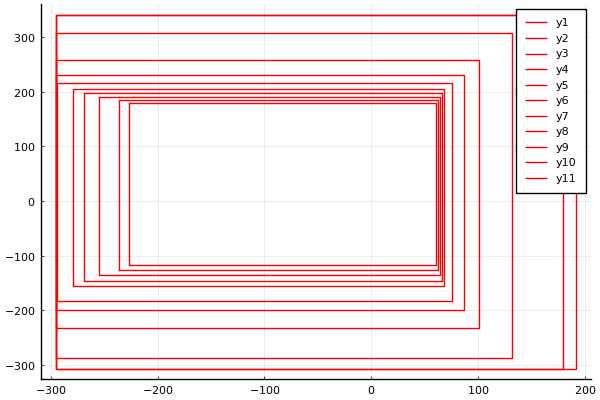

In [121]:
plt = plot()

inds = [1;5;6;11]

# todo_xs, todo_ys = x3s[inds,:], x4s[inds,:]

todo_xs, todo_ys = x1s, x2s

plt = plotBoxes!(plt, todo_xs[:,1], todo_xs[:,2], todo_ys[:,1], todo_ys[:,2], color=:red)

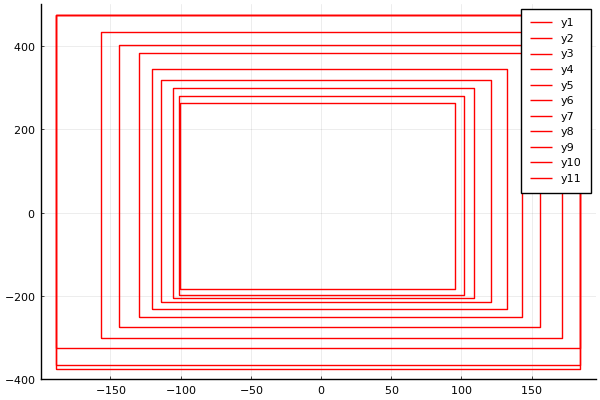

In [122]:
plt = plot()

# inds = [1;5;20;40]

# todo_xs, todo_ys = x3s[inds,:], x4s[inds,:]

todo_xs, todo_ys = x3s, x4s

plt = plotBoxes!(plt, todo_xs[:,1], todo_xs[:,2], todo_ys[:,1], todo_ys[:,2], color=:red)

In [123]:
x3s

11×2 Matrix{Float64}:
 -188.624  184.751
 -188.624  184.751
 -188.624  184.751
 -156.955  171.572
 -144.168  156.196
 -130.031  143.356
 -120.552  132.566
 -114.02   121.035
 -105.791  109.147
 -101.023  101.917
 -100.301   95.7645

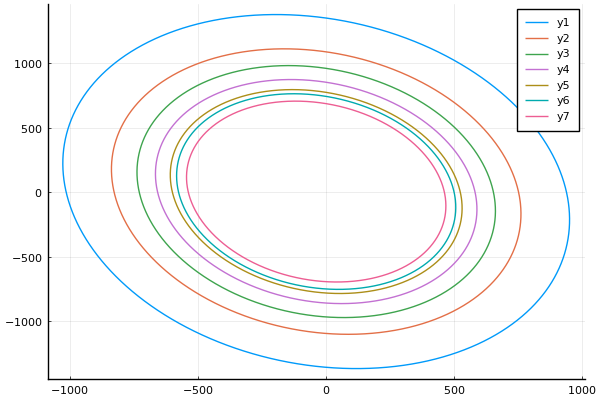

In [124]:
plt = plot()

# todo_ellipsoids = ellipsoids[inds]
todo_ellipsoids = ellipsoids

for (P, yc) in todo_ellipsoids
    Pp, ycp = P[1:2, 1:2], yc[1:2]
    plotEllipse!(plt, Pp, ycp)
end
plt

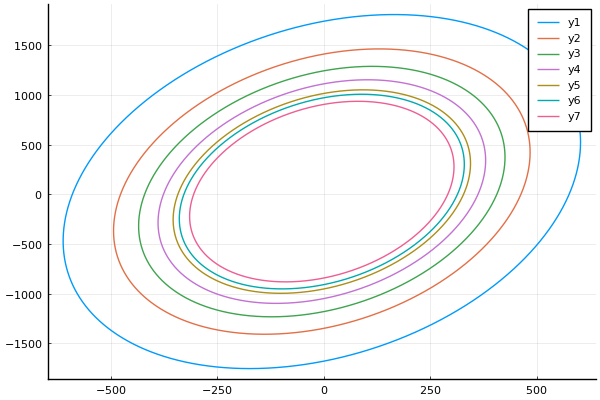

In [125]:
plt = plot()

# todo_ellipsoids = ellipsoids[inds]
todo_ellipsoids = ellipsoids

for (P, yc) in todo_ellipsoids
    Pp, ycp = P[3:4, 3:4], yc[3:4]
    plotEllipse!(plt, Pp, ycp)
end
plt

In [79]:
length(ellipsoids)

7

In [28]:
ellipsoids[1][1]

4×4 Matrix{Real}:
  2.44994    0.103172  -1.26275   -0.745631
  0.103172   2.11131   -0.354429  -0.209271
 -1.26275   -0.354429   6.42077    2.56114
 -0.745631  -0.209271   2.56114    3.59486

In [29]:
ellipsoids[10][1]

4×4 Matrix{Real}:
  2.449      0.103134  -1.26226   -0.745316
  0.103134   2.11051   -0.354309  -0.209192
 -1.26226   -0.354309   6.41843    2.56013
 -0.745316  -0.209192   2.56013    3.59342